<a href="https://colab.research.google.com/github/m607stars/Reading-WeeBit-with-LSTMs-CNNs/blob/main/WeeBit_CNN_LSTM_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Installs

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install torchviz

In [2]:
import numpy as np
import pandas as pd
import os
import torch
from nltk.tokenize import word_tokenize
from torchtext import vocab
import random
import nltk
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    print("Seeding done")
seed_everything(42)

Seeding done


In [5]:
VECTOR_PATH = '/content/drive/MyDrive/Readability_Research_Paper/'
VECTOR_NAME = 'glove.6B.300d.txt'

TEXT_LENGTH = 187
EMBEDDING_SIZE = 300
HIDDEN_SIZE = 200
BATCH_SIZE=16

embeddings = vocab.Vectors(VECTOR_NAME,VECTOR_PATH)

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


In [7]:
train_dataset = pd.read_csv('/content/drive/MyDrive/Readability_Research_Paper/train.csv')
train_dataset['readability'] = train_dataset['readability'].apply(lambda x: x-2)
train_dataset.head()

,text,readability
0,they sent me a salwar kameezpeacockblueand ano...,4
1,the chart shows each planet and its number of ...,0
2,this revision bite will help you understand wh...,4
3,what are powers and roots find out how they work,3
4,the wright brothers flew the first airplane ne...,0


In [8]:
test_dataset = pd.read_csv('/content/drive/MyDrive/Readability_Research_Paper/test.csv')
test_dataset['readability'] = test_dataset['readability'].apply(lambda x: x-2)
test_dataset.head()

,text,readability
0,to understand a work of art or a beautiful obj...,4
1,perhaps the most important of these is the use...,4
2,q what is a tornados favorite game a twister,0
3,the final thing to remember is there are lots ...,4
4,3d shapes have 3dimensions length width and de...,3


# Data pre-processing and DataLoaders

In [9]:
def get_word_to_index(texts):
    word_to_index = {
        '<PAD>':0,
        '<START>':1,
        '<END>':2,
    }
    ind = 3
    for text in texts:
        words = word_tokenize(text)
        for word in words:
            if word not in word_to_index.keys():
                word_to_index[word] = ind
                ind += 1
                
    return word_to_index   

word_to_index_dict = get_word_to_index(train_dataset['text'])
VOCABULARY_SIZE = len(word_to_index_dict.keys())
print(VOCABULARY_SIZE)

21072


In [10]:
def get_tensor_from_text(text):
    word_list = []
    words = word_tokenize(text)
    for word in words:
        word_list.append(word_to_index_dict[word])
    if len(word_list) > TEXT_LENGTH:
        word_list = word_list[:TEXT_LENGTH]
    else:
        word_list.extend([0]*(TEXT_LENGTH-len(word_list)))
    
    tensor_list = torch.tensor(word_list, device=device, dtype=torch.long)
    return tensor_list

In [11]:
class WeebitDataset(torch.utils.data.Dataset):
    def __init__(self,dataset):
        self.dataset = dataset
    
    def __getitem__(self,index): 
        text = self.dataset['text'].iloc[index]
        y = torch.tensor(self.dataset['readability'].iloc[index],dtype=torch.float,device=device)
        x = get_tensor_from_text(text)
        return x,y
    
    def __len__(self):
        return len(self.dataset)

In [12]:
def create_embedding_matrix(embeddings,vocabulary_size):  
    embedding_matrix = np.random.rand(vocabulary_size,EMBEDDING_SIZE)
    for string,index in word_to_index_dict.items():
        if not  all(x == 0 for x in embeddings[string].tolist()):
            embedding_matrix[index] = embeddings[string] 
    return embedding_matrix

In [13]:
embedding_matrix = create_embedding_matrix(embeddings,VOCABULARY_SIZE)

# Model and Training 

In [17]:
class ReadabilityModel_LSTM(torch.nn.Module):
    def __init__(self, embedding_matrix, hidden_size, num_of_layers):
        super().__init__()
        self.dropout_probability = 0.2
        self.embeddings_layer = torch.nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                                   padding_idx=0)
        self.embeddings_layer.weight = torch.nn.Parameter(torch.tensor(embedding_matrix, 
                                                                       dtype=torch.float32,
                                                                       device=device))
        self.embeddings_layer.weight.requires_grad = False
        self.lstm_layer = torch.nn.LSTM(300, hidden_size,
                                        num_layers=num_of_layers, dropout=self.dropout_probability,
                                        batch_first=True, bidirectional=True)
        self.linear_layer_1 = torch.nn.Linear(hidden_size,128)
        self.dropout_layer = torch.nn.Dropout(p=self.dropout_probability)
        self.leaky_relu = torch.nn.LeakyReLU()
        self.linear_layer_2 = torch.nn.Linear(128,5)

    def forward(self,x):
        x = self.embeddings_layer(x) #shape of x is 16,200,300
        lstm_output, (ht, ct) = self.lstm_layer(x)
        #Shape of lstm_output_1 is 16,50,512 
        #Shape of ht1 is 6,16,256 
        #Shape of ct2 is 6,16,256
        linear_output_1 = self.linear_layer_1(ht[-1])
        linear_output_1 = self.leaky_relu(linear_output_1)
        linear_output_1 = self.dropout_layer(linear_output_1)
        linear_output_2 = self.linear_layer_2(linear_output_1)
        output = linear_output_2
        return output

#Train

In [ ]:
def train(train_dataset,valid_dataset,epochs,learning_rate,train_batch_size,valid_batch_size,embedding_matrix,hidden_size, num_of_layers):
  loss_function = torch.nn.CrossEntropyLoss()

  trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=train_batch_size,
                                            drop_last=True)
  validloader = torch.utils.data.DataLoader(valid_dataset,batch_size=valid_batch_size,
                                            drop_last=True)

  model = ReadabilityModel_LSTM(embedding_matrix,
                                              hidden_size, num_of_layers)
  model = model.to(device)
  train_loss_list,valid_loss_list = [],[]
  train_accuracy_list,valid_accuracy_list = [],[]
  for epoch in range(0, epochs):
      epoch_loss = 0.0
      model.train()
      train_correct = 0
      # learning_rate = 0.001/(epoch+1)
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
      for i, data in enumerate(trainloader, 0):
          inputs, targets = data
          optimizer.zero_grad()
          targets = torch.tensor(targets,dtype=torch.long,device=device)
          outputs = model(inputs)
          output_ids = torch.argmax(outputs, dim=1)

          loss = loss_function(outputs, targets)
          epoch_loss += loss.item()

          loss.backward()
          optimizer.step()
          train_correct += (output_ids == targets).float().sum()

      train_accuracy = 100 * train_correct / len(train_dataset)
      epoch_loss /= len(trainloader) / train_batch_size 
      train_loss_list.append(epoch_loss)
      train_accuracy_list.append(train_accuracy)

      with torch.no_grad():
        validation_loss = 0.0
        valid_correct = 0
        for i, data in enumerate(validloader, 0):
            model.eval()
            inputs, targets = data
            targets = torch.tensor(targets,dtype=torch.long,device=device)
            outputs = model(inputs)
            output_ids = torch.argmax(outputs, dim=1)
            # outputs = outputs.squeeze(1)
            loss = loss_function(outputs, targets)
            validation_loss += loss.item()
            valid_correct += (output_ids == targets).float().sum()

      valid_accuracy = 100 * valid_correct / len(valid_dataset)  
      validation_loss /= len(validloader) / valid_batch_size 
      valid_loss_list.append(validation_loss)
      valid_accuracy_list.append(valid_accuracy)
      print(f'Epoch:{epoch}, Training Loss:{epoch_loss} Validation Loss: {validation_loss} \n Training accuracy:{train_accuracy} Validation Accuracy: {valid_accuracy} ')

      torch.save(model,'/content/drive/MyDrive/Readability_Research_Paper/models/lstm_{}.pkl'.format(epoch))    
      print('--------------------------------')

  return train_loss_list,valid_loss_list,train_accuracy_list,valid_accuracy_list,model

In [ ]:
from sklearn.model_selection import train_test_split

split_train_df, split_val_df = train_test_split(train_dataset,test_size=0.1,stratify=train_dataset['readability'])

In [ ]:
train_dataset_torch = WeebitDataset(split_train_df)
valid_dataset_torch = WeebitDataset(split_val_df)
EMBEDDING_SIZE = 300 
hidden_size = 256
num_of_layers = 3
train_batch_size = 16
valid_batch_size = 1
epochs = 100
learning_rate = 0.00005

In [ ]:
train_loss_list,valid_loss_list,train_accuracy_list,valid_accuracy_list,model = train(train_dataset_torch,valid_dataset_torch,epochs,learning_rate,
                                                                                      train_batch_size,valid_batch_size,
                                                                                      embedding_matrix,hidden_size, num_of_layers)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:0, Training Loss:25.655448518480572 Validation Loss: 1.5561500034332276 
 Training accuracy:23.244443893432617 Validation Accuracy: 32.0 
--------------------------------
Epoch:1, Training Loss:21.6620885848999 Validation Loss: 1.2536495051383971 
 Training accuracy:36.266666412353516 Validation Accuracy: 39.60000228881836 
--------------------------------
Epoch:2, Training Loss:19.37240241595677 Validation Loss: 1.209604701280594 
 Training accuracy:36.22222137451172 Validation Accuracy: 44.80000305175781 
--------------------------------
Epoch:3, Training Loss:18.714037888390678 Validation Loss: 1.1595785026550294 
 Training accuracy:38.488887786865234 Validation Accuracy: 45.20000076293945 
--------------------------------
Epoch:4, Training Loss:17.62905853816441 Validation Loss: 1.1352643704414367 
 Training accuracy:42.71111297607422 Validation Accuracy: 45.20000076293945 
--------------------------------
Epoch:5, Training Loss:17.16478293963841 Validation Loss: 1.1878859128

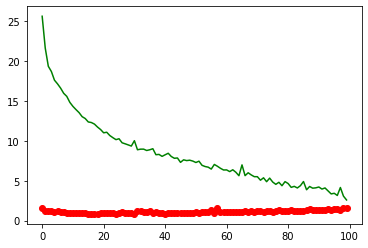

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list,'g',valid_loss_list , 'ro')
plt.show()

In [31]:
def get_tensor_from_text_test(text,dataset):
    word_list = []
    train_word_to_index_dict = get_word_to_index(dataset['text'])
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word in train_word_to_index_dict.keys()]
    for word in words:
        word_list.append(train_word_to_index_dict[word])
    if len(word_list) > TEXT_LENGTH:
        word_list = word_list[:TEXT_LENGTH]
    else:
        word_list.extend([0]*(TEXT_LENGTH-len(word_list)))
    
    tensor_list = torch.tensor(word_list, device=device, dtype=torch.long)
    return tensor_list

class WeebitTestDataset(torch.utils.data.Dataset):
    def __init__(self,test_dataset,train_dataset):
        self.dataset = test_dataset
        self.train_dataset = train_dataset 
    
    def __getitem__(self,index): 
        text = self.dataset['text'].iloc[index]
        x = get_tensor_from_text_test(text,self.train_dataset)
        y = torch.tensor(self.dataset['readability'].iloc[index],dtype=torch.float,device=device)
        return x,y
    
    def __len__(self):
        return len(self.dataset)


def test(dataset):
  testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=1)
  with torch.no_grad():   
    model = torch.load('/content/drive/MyDrive/Readability_Research_Paper/models/lstm_88.pkl')
    model.eval()
    test_correct = 0
    target_list = []
    output_list = []
    for i, data in enumerate(testloader, 0):
      inputs, targets = data
      # print(targets.item())
      target_list.append(targets.item())
      targets = torch.tensor(targets,dtype=torch.long,device=device)
      outputs = model(inputs)
      output_ids = torch.argmax(outputs, dim=1)
      output_list.append(output_ids.item())
      # outputs = outputs.squeeze(1)
      test_correct += (output_ids == targets).float().sum()

    test_accuracy = 100 * test_correct / len(dataset)
    confusion_matrix_calc = confusion_matrix(target_list,output_list)
    return test_accuracy, confusion_matrix_calc

In [32]:
weebit_test_dataset = WeebitTestDataset(test_dataset, train_dataset)
accuracy, confusion_matrix_calc = test(weebit_test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [35]:
print(accuracy)
print(confusion_matrix_calc)

tensor(67.2000, device='cuda:0')
[[77 15  4  3  1]
 [27 37 34  2  0]
 [19 25 54  2  0]
 [ 2  0  2 90  6]
 [ 0  0  1 21 78]]
